In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
def maximal_coupling_categorical(p_weights, q_weights):
    p_weights = np.array(p_weights)
    q_weights = np.array(q_weights)
    r = np.minimum(p_weights, q_weights)
    alpha = np.sum(r)

    if np.random.rand() < alpha:
        r_norm = r / alpha
        idx = np.random.choice(len(r), p=r_norm)
        return idx, idx
    else:
        p_res = (p_weights - r)
        p_res /= p_res.sum()
        q_res = (q_weights - r)
        q_res /= q_res.sum()
        i = np.random.choice(len(p_res), p=p_res)
        j = np.random.choice(len(q_res), p=q_res)
        return i, j

In [3]:
p = lambda x: norm.pdf(x, loc=0, scale=1)
q = lambda x: norm.pdf(x, loc=1, scale=1)
p_hat = lambda x: norm.pdf(x, loc=0.5, scale=np.sqrt(2))
q_hat = p_hat  # same proposal

In [4]:
xs = np.linspace(-10, 10, 10000)
M_p = np.max(p(xs) / p_hat(xs))
M_q = np.max(q(xs) / q_hat(xs))

In [5]:
def sample_gamma_hat(N):
    Zs = np.random.normal(0.5, np.sqrt(2), size=N)
    return Zs, Zs  # Diagonal coupling: X_i = Y_i

In [6]:
def sample_independent_pq():
    return np.random.normal(0, 1), np.random.normal(1, 1)

In [ ]:
def ensemble_rejection_coupling(N=10):
    AX = AY = False  # Acceptance flags

    while not (AX or AY):
        X_hat, Y_hat = sample_gamma_hat(N)
        U = np.random.uniform()

        w_X = np.array([p(xi) / p_hat(xi) for xi in X_hat])
        w_Y = np.array([q(yi) / q_hat(yi) for yi in Y_hat])
        Z_X_hat = np.mean(w_X)
        Z_Y_hat = np.mean(w_Y)

        W_X = w_X / (N * Z_X_hat)
        W_Y = w_Y / (N * Z_Y_hat)

        I, J = maximal_coupling_categorical(W_X, W_Y)

        Z_X_bar = Z_X_hat + (1 / N) * (M_p - w_X[I])
        Z_Y_bar = Z_Y_hat + (1 / N) * (M_q - w_Y[J])

        X1 = X_hat[I]
        Y1 = Y_hat[J]

        if U < Z_X_hat / Z_X_bar:
            AX = True
        if U < Z_Y_hat / Z_Y_bar:
            AY = True

    X2, Y2 = sample_independent_pq()

    X = X1 if AX else X2
    Y = Y1 if AY else Y2

    return X, Y

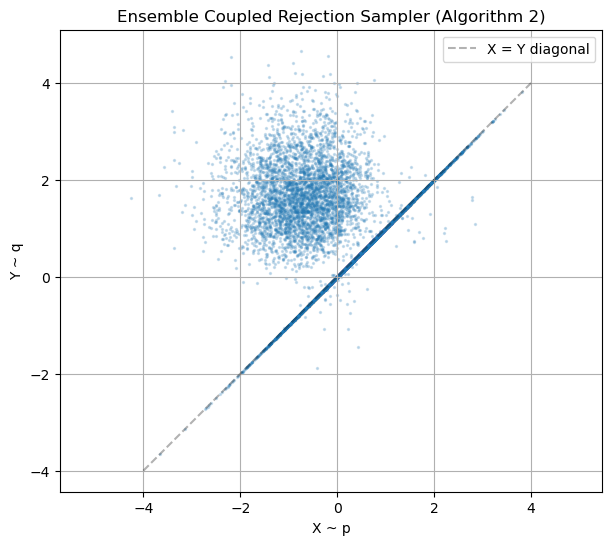

In [8]:
samples = [ensemble_rejection_coupling(N=10) for _ in range(10000)]
xs, ys = zip(*samples)

import matplotlib.pyplot as plt
plt.figure(figsize=(7, 6))
plt.scatter(xs, ys, s=2, alpha=0.2)
plt.plot([-4, 4], [-4, 4], 'k--', label="X = Y diagonal", alpha=0.3)
plt.xlabel('X ~ p')
plt.ylabel('Y ~ q')
plt.title('Ensemble Coupled Rejection Sampler (Algorithm 2)')
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()
